In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
from numpy.random import seed
seed(41)
from tensorflow import set_random_seed
set_random_seed(42)

In [3]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [4]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

2660 train sequences
666 valid sequences


In [5]:
max_len = 1500

In [6]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [8]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (2660, 1500)
x_valid shape: (666, 1500)


In [14]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [15]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1

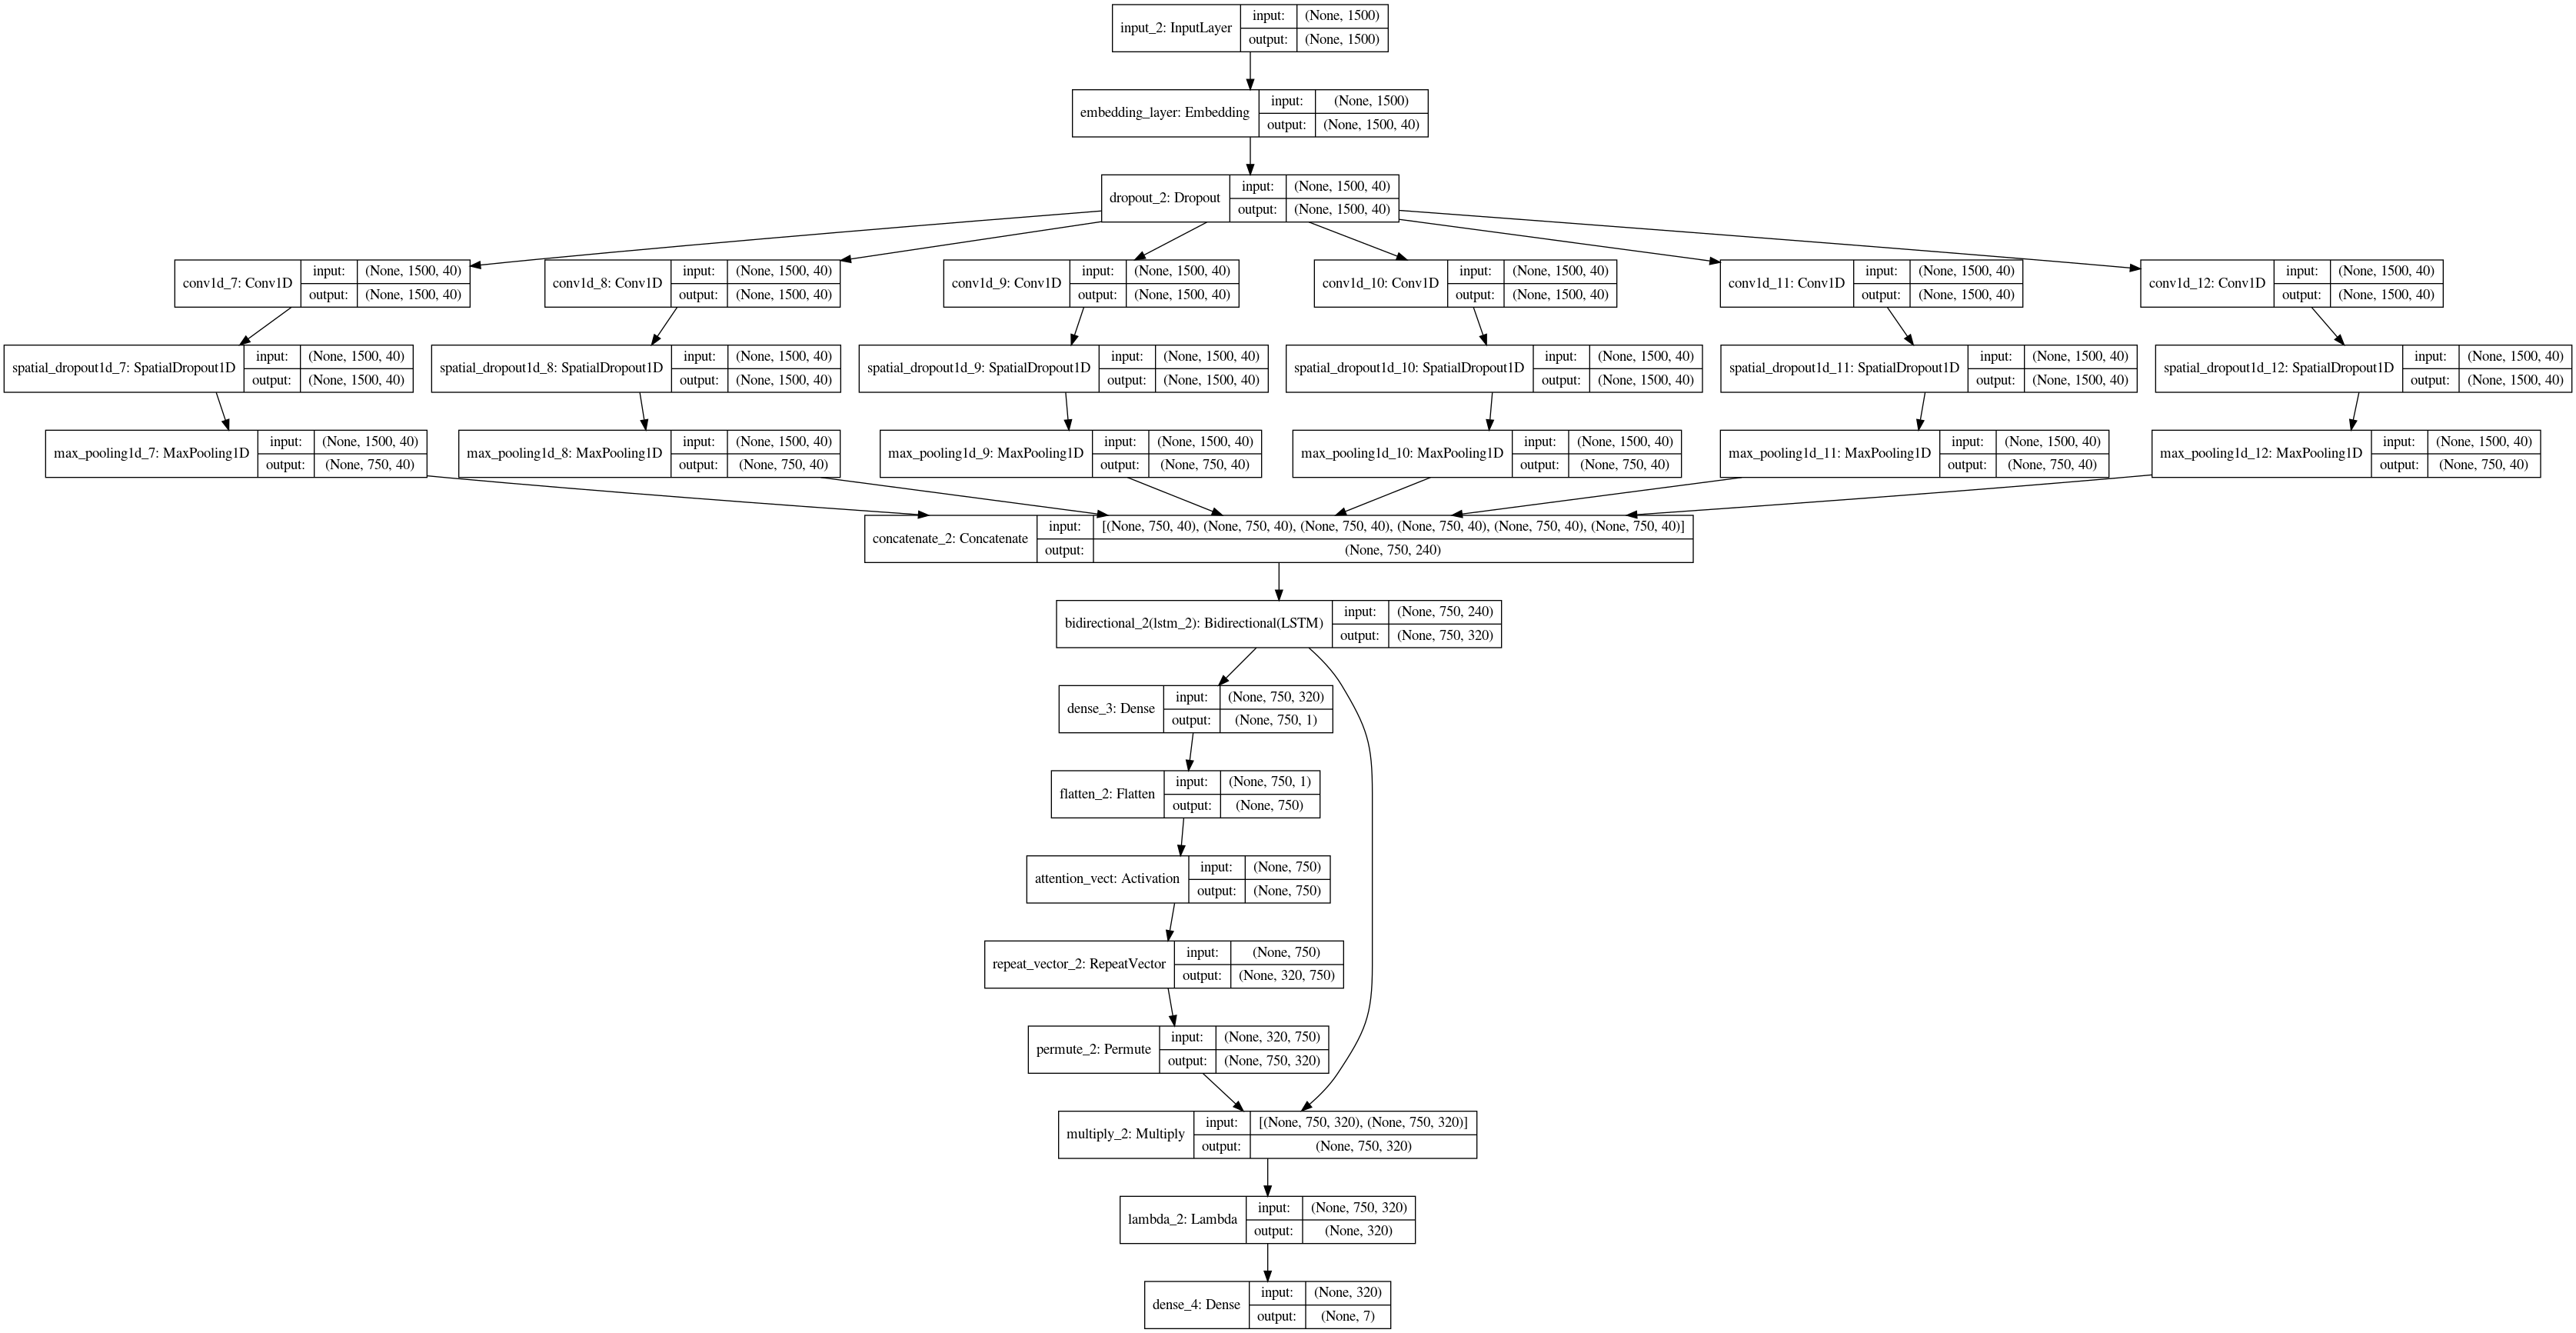

In [17]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 40
# Convolution
filters = 40
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='models/model1_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
ckpt = ModelCheckpoint(filepath='models/model1_weights.hdf5', verbose=1, save_best_only=True)
# Train, train, train
history1 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=batch_size, epochs=50,
                    class_weight = class_weights,
                    validation_data=[x_valid_pad, y_valid_OH], 
                    callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 354s 133ms/step - loss: 1.4797 - accuracy: 0.5154 - val_loss: 1.5771 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.57709, saving model to models/model1_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 335s 126ms/step - loss: 1.3568 - accuracy: 0.5357 - val_loss: 1.2727 - val_accuracy: 0.5646

Epoch 00002: val_loss improved from 1.57709 to 1.27269, saving model to models/model1_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 326s 123ms/step - loss: 1.2780 - accuracy: 0.5767 - val_loss: 1.2314 - val_accuracy: 0.5991

Epoch 00003: val_loss improved from 1.27269 to 1.23139, saving model to models/model1_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 313s 118ms/step - loss: 1.2013 - accuracy: 0.5992 - val_loss: 1.1505 - val_accuracy: 0.6096

Epoch 00004: val

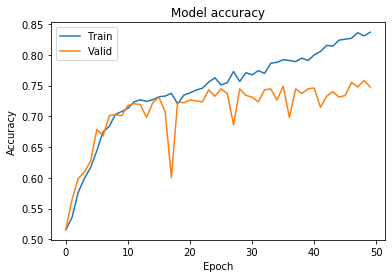

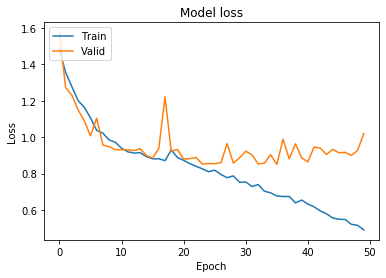

In [19]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
history_plot(history1)

In [20]:
model = load_model('models/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)
# Best score ever got so far

[0.8502238043793687, 0.7492492198944092]

In [22]:
y_pred1 = model.predict(x_valid_pad)
y_pred1_indices = OH_to_label_indices(y_pred1)
y_pred1_label = indices_to_cat(y_pred1_indices)

In [23]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

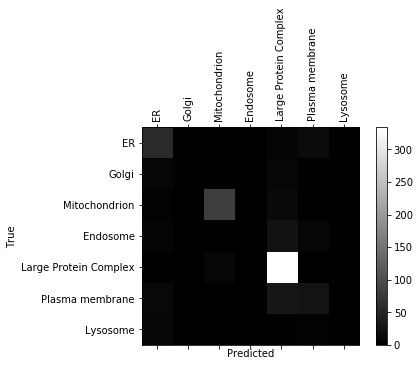

In [24]:
confusion_plot(y_valid, y_pred1_label, cat)

In [25]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)

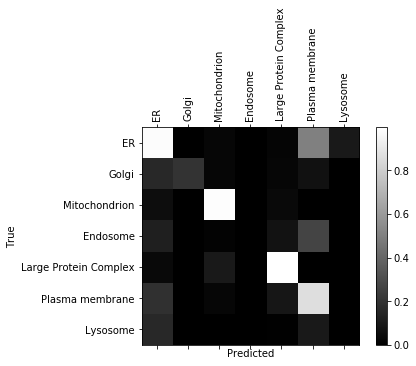

In [26]:
conf = confusion_plot_norm(y_valid, y_pred1_label, cat, axis=1)

In [27]:
conf

array([[ 56,   0,   2,   0,   7,  15,   1],
       [  9,   2,   2,   0,   8,   2,   0],
       [  3,   0,  81,   0,  12,   0,   0],
       [  7,   0,   1,   0,  24,   8,   0],
       [  2,   0,   8,   0, 334,   0,   0],
       [ 11,   0,   2,   0,  29,  26,   0],
       [  9,   0,   0,   0,   2,   3,   0]])

In [28]:
print(classification_report(y_valid, y_pred1_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.69      0.63        81
             Endosome       0.00      0.00      0.00        40
                Golgi       1.00      0.09      0.16        23
Large Protein Complex       0.80      0.97      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.84      0.84      0.84        96
      Plasma membrane       0.48      0.38      0.43        68

             accuracy                           0.75       666
            macro avg       0.53      0.43      0.42       666
         weighted avg       0.69      0.75      0.70       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 2
Sigmoid activation instead of softmax

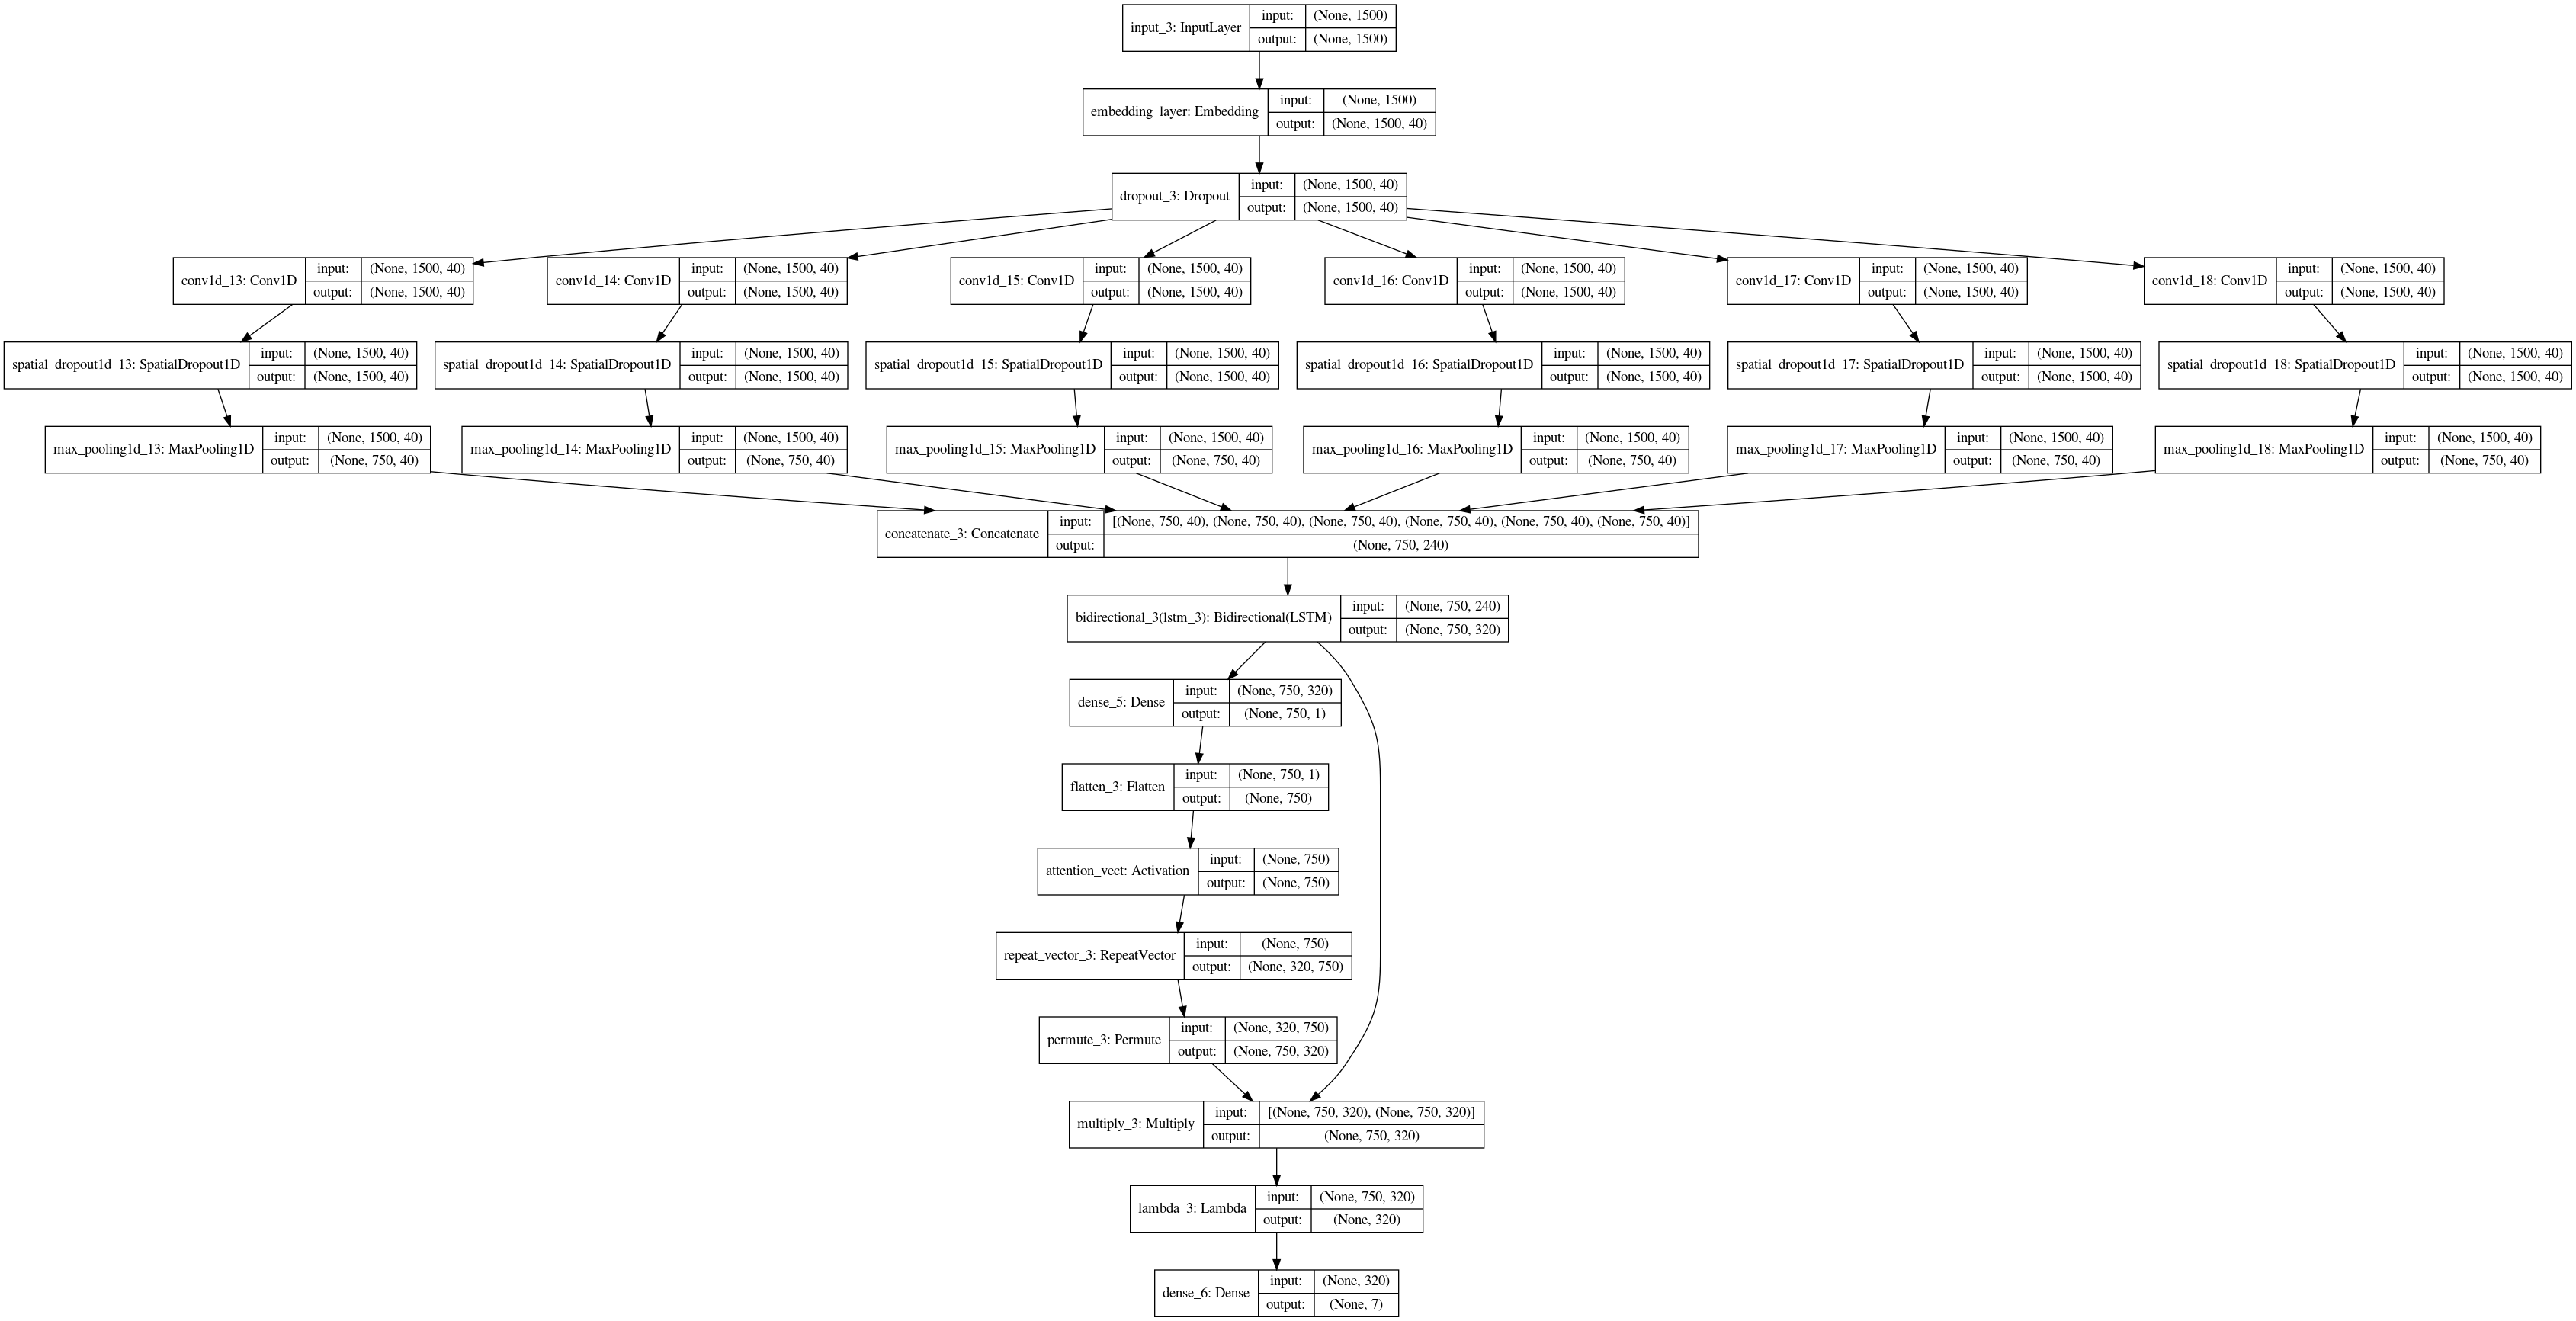

In [67]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 40
# Convolution
filters = 40
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='sigmoid')(sent_representation)

model2 = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
plot_model(model2, to_file='models/model2_plot.png', show_shapes=True, show_layer_names=True)

In [69]:
ckpt = ModelCheckpoint(filepath='models/model2_weights.hdf5', verbose=1, save_best_only=True)
# Train, train, train
history2 = model2.fit(x_train_pad, y_train_OH, 
                    batch_size=batch_size, epochs=50,
                    class_weight = class_weights,
                    validation_data=[x_valid_pad, y_valid_OH], 
                    callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 351s 132ms/step - loss: 1.4939 - accuracy: 0.5139 - val_loss: 1.4598 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.45985, saving model to models/model2_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 314s 118ms/step - loss: 1.4222 - accuracy: 0.5165 - val_loss: 1.3753 - val_accuracy: 0.5285

Epoch 00002: val_loss improved from 1.45985 to 1.37529, saving model to models/model2_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 317s 119ms/step - loss: 1.3396 - accuracy: 0.5387 - val_loss: 1.2800 - val_accuracy: 0.5781

Epoch 00003: val_loss improved from 1.37529 to 1.28003, saving model to models/model2_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 312s 117ms/step - loss: 1.2377 - accuracy: 0.5910 - val_loss: 1.2097 - val_accuracy: 0.5931

Epoch 00004: val_loss improved from 1.28003 to 1.20966, saving m

2660/2660 [==============================] - 375s 141ms/step - loss: 0.6341 - accuracy: 0.7711 - val_loss: 0.9039 - val_accuracy: 0.7252

Epoch 00038: val_loss did not improve from 0.87273
Epoch 39/50
2660/2660 [==============================] - 377s 142ms/step - loss: 0.5969 - accuracy: 0.7812 - val_loss: 1.0296 - val_accuracy: 0.6787

Epoch 00039: val_loss did not improve from 0.87273
Epoch 40/50
2660/2660 [==============================] - 442s 166ms/step - loss: 0.5883 - accuracy: 0.7771 - val_loss: 0.9196 - val_accuracy: 0.7162

Epoch 00040: val_loss did not improve from 0.87273
Epoch 41/50
2660/2660 [==============================] - 324s 122ms/step - loss: 0.5550 - accuracy: 0.7932 - val_loss: 1.0326 - val_accuracy: 0.6742

Epoch 00041: val_loss did not improve from 0.87273
Epoch 42/50
2660/2660 [==============================] - 315s 118ms/step - loss: 0.5671 - accuracy: 0.7898 - val_loss: 0.9455 - val_accuracy: 0.7087

Epoch 00042: val_loss did not improve from 0.87273
Epoch 4

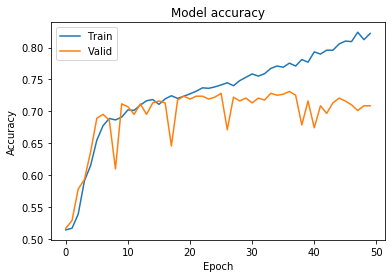

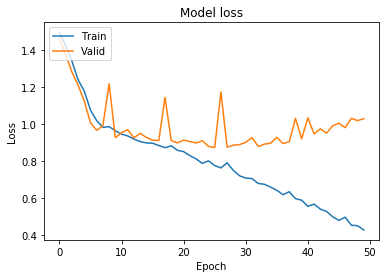

In [70]:
history_plot(history2)

In [87]:
model2 = load_model('models/model2_weights.hdf5')
model2.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.872729140716988, 0.7282282114028931]

In [88]:
y_pred2 = model2.predict(x_valid_pad)
y_pred2_indices = OH_to_label_indices(y_pred2)
y_pred2_label = indices_to_cat(y_pred2_indices)

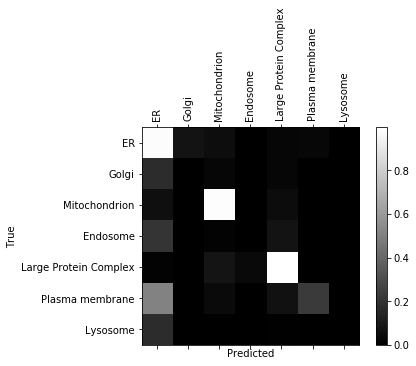

In [89]:
conf2 = confusion_plot_norm(y_valid, y_pred2_label, cat, axis=1)

In [90]:
conf2

array([[ 66,   1,   4,   0,   9,   1,   0],
       [ 12,   0,   2,   0,   9,   0,   0],
       [  4,   0,  75,   0,  17,   0,   0],
       [ 14,   0,   1,   0,  25,   0,   0],
       [  1,   0,   6,   1, 336,   0,   0],
       [ 34,   0,   3,   0,  23,   8,   0],
       [ 12,   0,   0,   0,   2,   0,   0]])

In [91]:
print(classification_report(y_valid, y_pred2_label))

                       precision    recall  f1-score   support

                   ER       0.46      0.81      0.59        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.80      0.98      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.82      0.78      0.80        96
      Plasma membrane       0.89      0.12      0.21        68

             accuracy                           0.73       666
            macro avg       0.42      0.38      0.35       666
         weighted avg       0.68      0.73      0.66       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
print(classification_report(y_valid, y_pred1_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.69      0.63        81
             Endosome       0.00      0.00      0.00        40
                Golgi       1.00      0.09      0.16        23
Large Protein Complex       0.80      0.97      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.84      0.84      0.84        96
      Plasma membrane       0.48      0.38      0.43        68

             accuracy                           0.75       666
            macro avg       0.53      0.43      0.42       666
         weighted avg       0.69      0.75      0.70       666



Conclusion:
    
    Softmax is better

# Model 3

Add a dense layer on top of attention

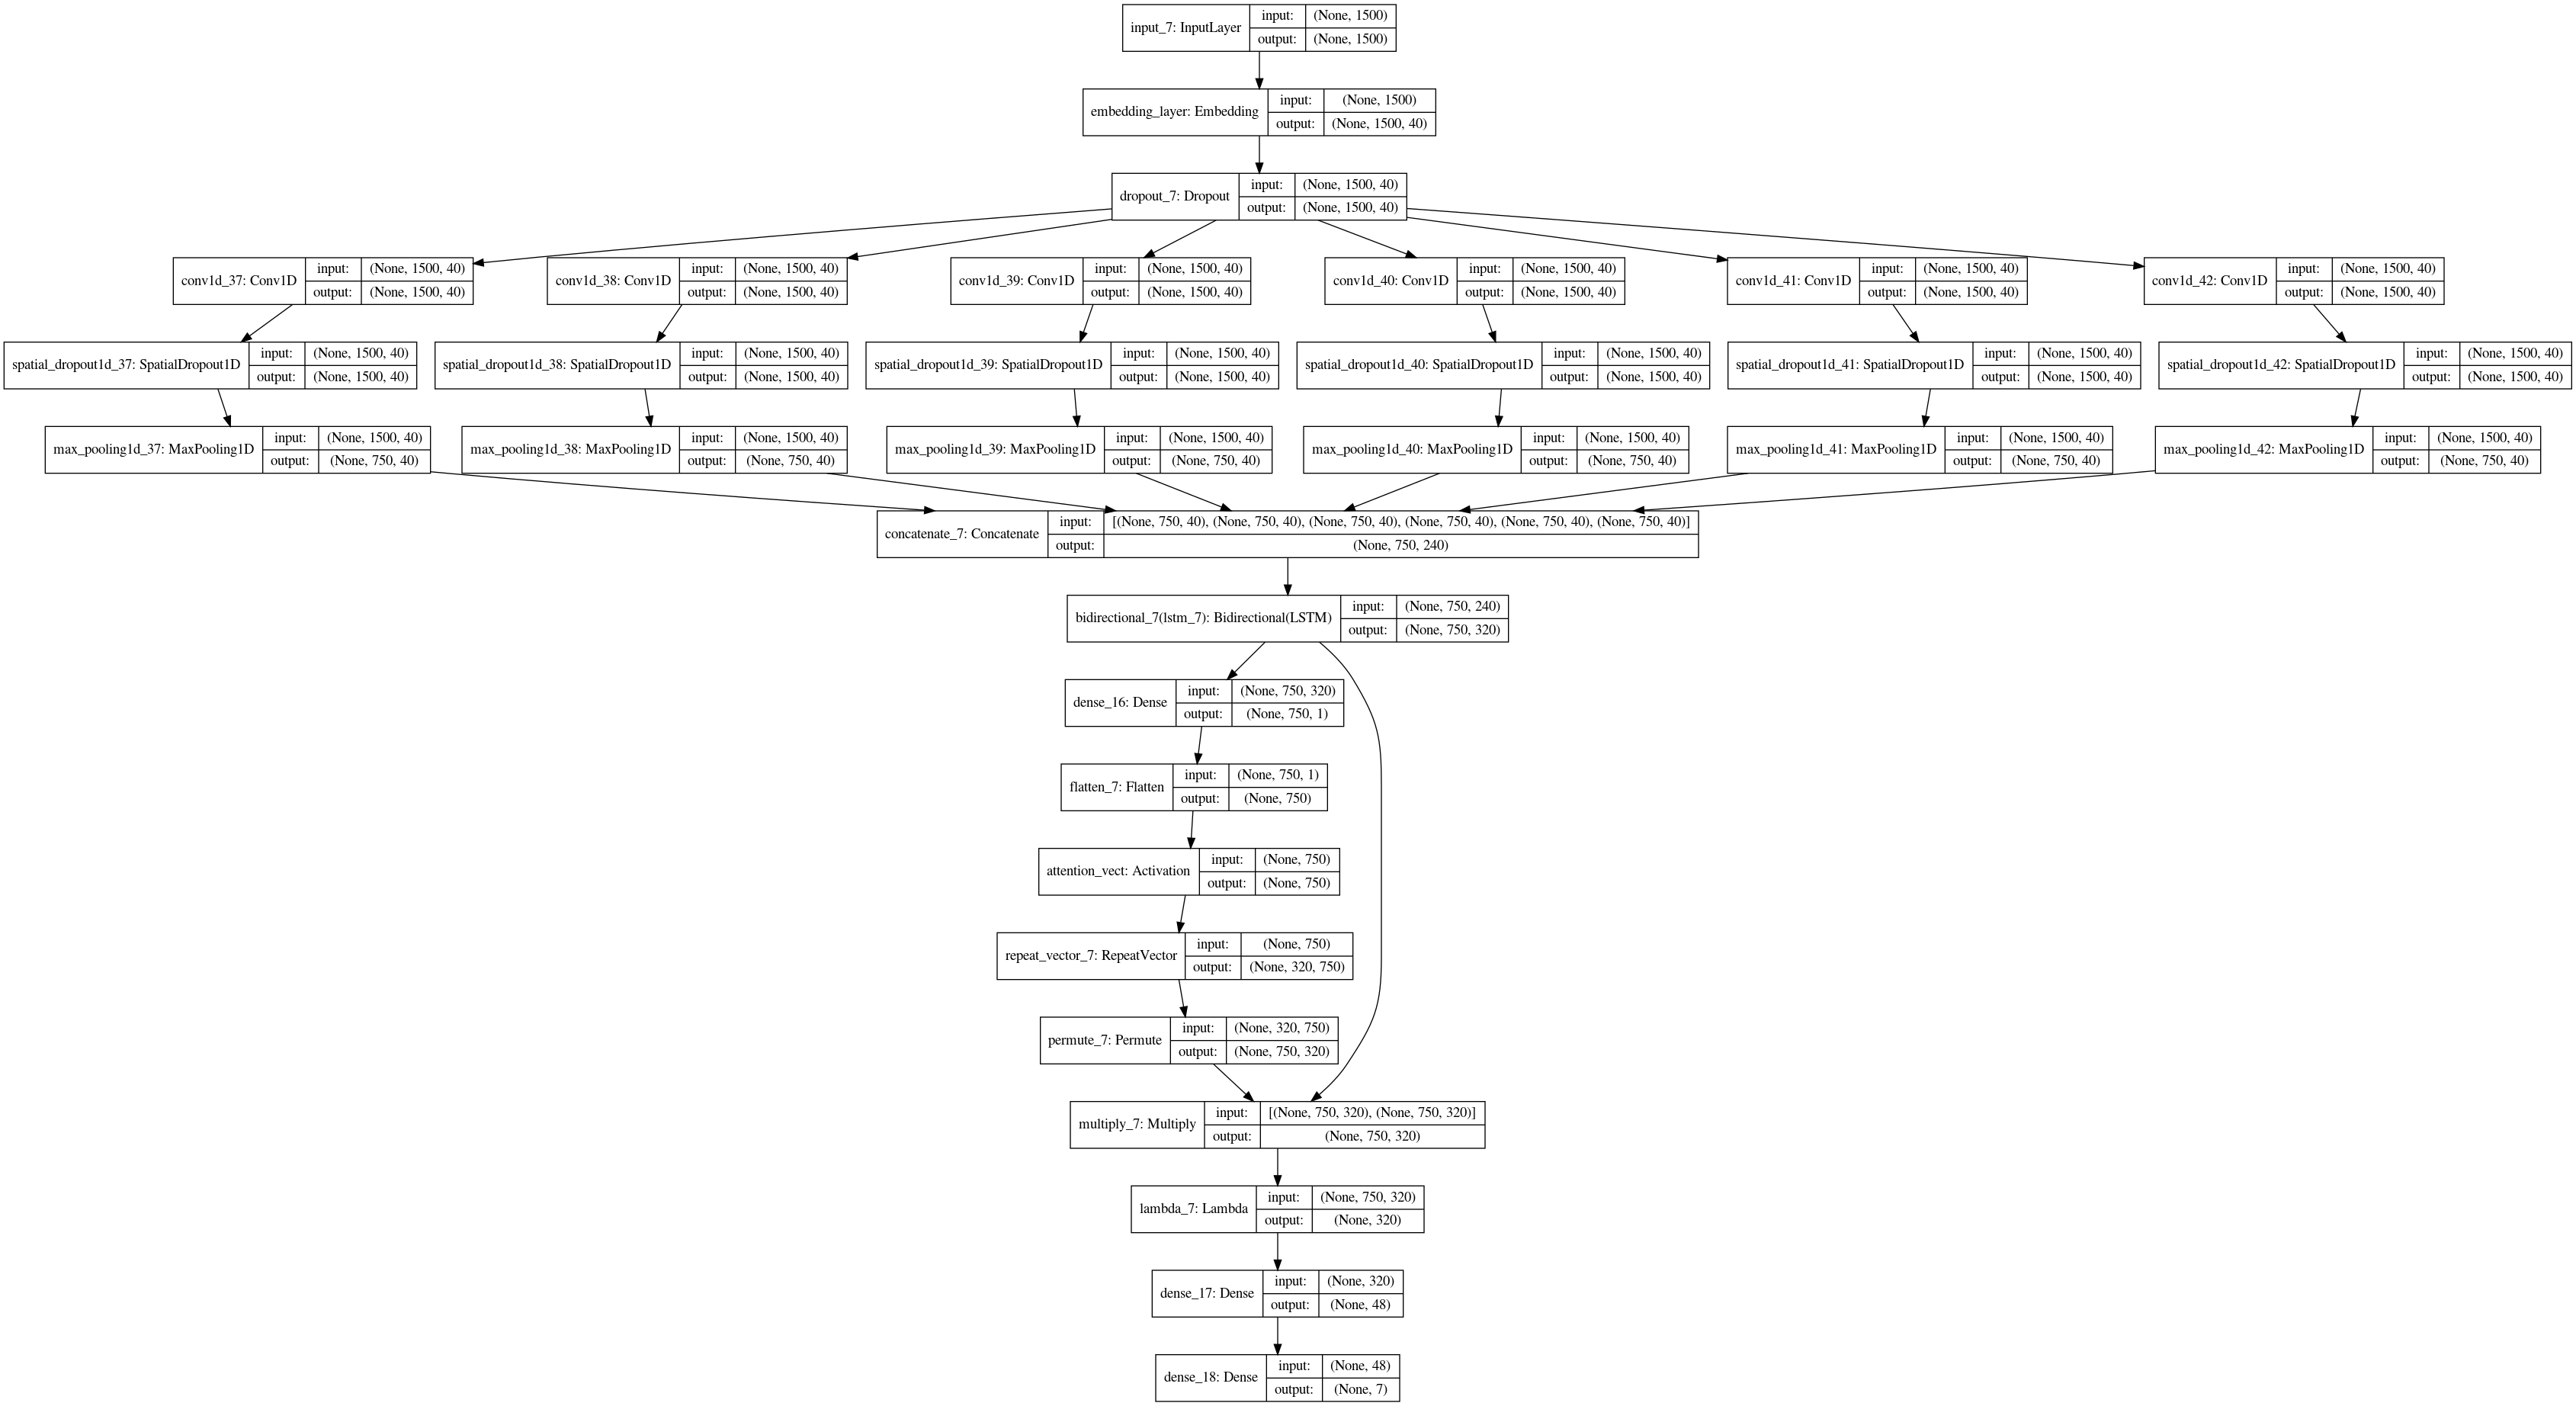

In [96]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 40
# Convolution
filters = 40
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)
dense = Dense(48)(sent_representation)
probabilities = Dense(7, activation='softmax')(dense)

model3 = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model3.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
plot_model(model3, to_file='models/model3_plot.png', show_shapes=True, show_layer_names=True)

In [97]:
ckpt = ModelCheckpoint(filepath='models/model3_weights.hdf5', verbose=1, save_best_only=True)
# Train, train, train
history3 = model3.fit(x_train_pad, y_train_OH, 
                    batch_size=batch_size, epochs=50,
                    class_weight = class_weights,
                    validation_data=[x_valid_pad, y_valid_OH], 
                    callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 343s 129ms/step - loss: 1.4759 - accuracy: 0.5086 - val_loss: 1.5429 - val_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 1.54292, saving model to models/model3_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 314s 118ms/step - loss: 1.3955 - accuracy: 0.5218 - val_loss: 1.4534 - val_accuracy: 0.5390

Epoch 00002: val_loss improved from 1.54292 to 1.45341, saving model to models/model3_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 311s 117ms/step - loss: 1.3058 - accuracy: 0.5564 - val_loss: 1.3995 - val_accuracy: 0.5556

Epoch 00003: val_loss improved from 1.45341 to 1.39948, saving model to models/model3_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 308s 116ms/step - loss: 1.2111 - accuracy: 0.5887 - val_loss: 1.4041 - val_accuracy: 0.5661

Epoch 00004: val_loss did not improve from 1.39948
Epoch 5/50
26

2660/2660 [==============================] - 308s 116ms/step - loss: 0.6456 - accuracy: 0.7989 - val_loss: 0.8591 - val_accuracy: 0.7432

Epoch 00039: val_loss improved from 0.87101 to 0.85910, saving model to models/model3_weights.hdf5
Epoch 40/50
2660/2660 [==============================] - 308s 116ms/step - loss: 0.5984 - accuracy: 0.8109 - val_loss: 0.9765 - val_accuracy: 0.6997

Epoch 00040: val_loss did not improve from 0.85910
Epoch 41/50
2660/2660 [==============================] - 308s 116ms/step - loss: 0.5838 - accuracy: 0.8229 - val_loss: 0.8837 - val_accuracy: 0.7492

Epoch 00041: val_loss did not improve from 0.85910
Epoch 42/50
2660/2660 [==============================] - 309s 116ms/step - loss: 0.5830 - accuracy: 0.8199 - val_loss: 1.0565 - val_accuracy: 0.6336

Epoch 00042: val_loss did not improve from 0.85910
Epoch 43/50
2660/2660 [==============================] - 308s 116ms/step - loss: 0.5476 - accuracy: 0.8203 - val_loss: 1.0439 - val_accuracy: 0.7162

Epoch 0004

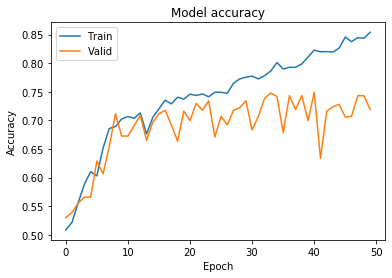

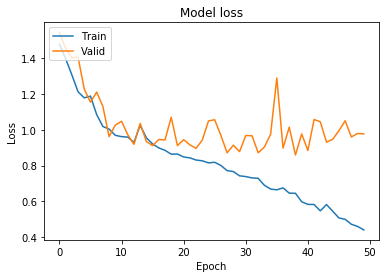

In [98]:
history_plot(history3)

In [99]:
model3 = load_model('models/model3_weights.hdf5')
model3.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 22s 33ms/step


[0.859100730569513, 0.7432432174682617]

In [100]:
y_pred3 = model3.predict(x_valid_pad)
y_pred3_indices = OH_to_label_indices(y_pred3)
y_pred3_label = indices_to_cat(y_pred3_indices)

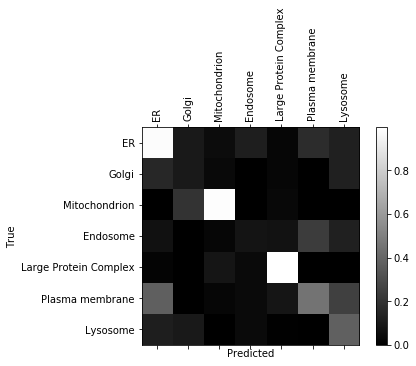

In [101]:
conf3 = confusion_plot_norm(y_valid, y_pred3_label, cat, axis=1)

In [102]:
conf3

array([[ 58,   1,   4,   3,   9,   5,   1],
       [  9,   1,   3,   0,   9,   0,   1],
       [  0,   2,  83,   0,  11,   0,   0],
       [  4,   0,   2,   2,  24,   7,   1],
       [  1,   0,   7,   1, 335,   0,   0],
       [ 22,   0,   2,   1,  28,  13,   2],
       [  7,   1,   0,   1,   2,   0,   3]])

In [103]:
print(classification_report(y_valid, y_pred3_label))

                       precision    recall  f1-score   support

                   ER       0.57      0.72      0.64        81
             Endosome       0.25      0.05      0.08        40
                Golgi       0.20      0.04      0.07        23
Large Protein Complex       0.80      0.97      0.88       344
             Lysosome       0.38      0.21      0.27        14
        Mitochondrion       0.82      0.86      0.84        96
      Plasma membrane       0.52      0.19      0.28        68

             accuracy                           0.74       666
            macro avg       0.51      0.44      0.44       666
         weighted avg       0.69      0.74      0.69       666



In [104]:
print(classification_report(y_valid, y_pred1_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.69      0.63        81
             Endosome       0.00      0.00      0.00        40
                Golgi       1.00      0.09      0.16        23
Large Protein Complex       0.80      0.97      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.84      0.84      0.84        96
      Plasma membrane       0.48      0.38      0.43        68

             accuracy                           0.75       666
            macro avg       0.53      0.43      0.42       666
         weighted avg       0.69      0.75      0.70       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Does not significantly improves the model BUT I ot improvment on Lysosome and Endosome (from 0 to small number)

## Embedding Analysis

In [30]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(22, 40)

In [31]:
def plot_embedding(embedding, aa):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none')
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### PCA plot

original shape:    (22, 40)
transformed shape: (22, 2)


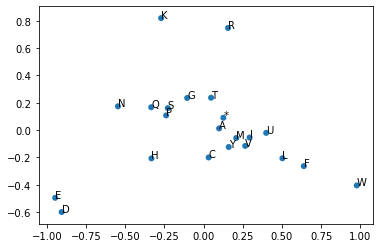

In [32]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
plot_embedding(embedding_pca, aa)

### t-SNE plot

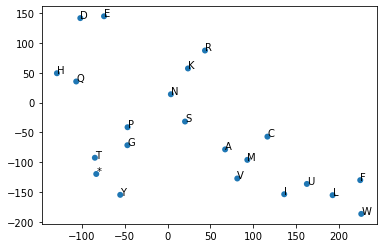

In [35]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=4)
embedding_tSNE = tSNE.fit_transform(embedding)
plot_embedding(embedding_tSNE, aa)

### UMAP plot

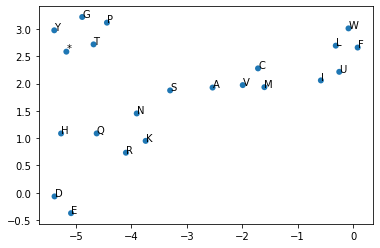

In [39]:
# umap plots of Embedding 
Umap = umap.UMAP(n_components=2, n_neighbors= 3)
embedding_Umap = Umap.fit_transform(embedding)
plot_embedding(embedding_Umap, aa)

## Attention Layer Analysis

In [40]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

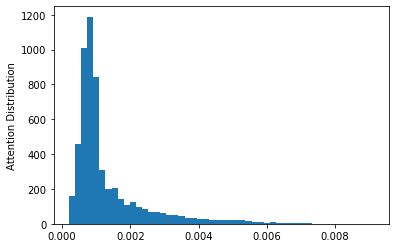

In [41]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

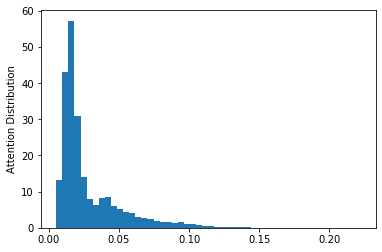

In [42]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [48]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [49]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [50]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [51]:
# Number of highest values to select
nb_max = 30
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [52]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
0,M,G,E,L,P,L,D,I,N,I,Q,E,P,R,W,D,Q,S,T,F,L,G,R,A,R,H,F,F,T,V,T,D,P,R,N,L,L,L,S,G,A,Q,L,E,A,S,R,N,I,V,Q,N,Y,R,A,G,V,V,T,P,G,I,T,E,D,Q,L,W,R,A,K,Y,V,Y,D,S,A,F,H,P,D,T,G,E,K,V,V,L,I,G,R,M,S,A,Q,V,P,M,N,M,T,I,T,G,C,M,L,T,F,Y,R,K,T,P,T,V,V,F,W,Q,W,V,N,Q,S,F,N,A,I,V,N,Y,S,N,R,S,G,D,T,P,I,T,V,R,Q,L,G,T,A,Y,V,S,A,T,T,G,A,V,A,T,A,L,G,L,K,S,L,T,K,H,L,P,P,L,V,G,R,F,V,P,F,A,A,V,A,A,A,N,C,I,N,I,P,L,M,R,Q,R,E,L,Q,V,G,I,P,V,A,D,E,A,G,Q,R,L,G,Y,S,V,T,A,A,K,Q,G,I,F,Q,V,V,I,S,R,I,C,M,A,I,P,A,M,A,I,P,P,L,I,M,D,T,L,E,K,K,D,F,L,K,R,R,P,W,L,G,A,P,L,Q,V,G,L,V,G,F,C,L,V,F,A,T,P,L,C,C,A,L,F,P,Q,K,S,S,I,H,I,S,N,L,E,P,E,L,R,A,Q,I,H,E,Q,N,P,S,V,E,V,V,Y,Y,N,K,G,L


## Error Analysis

In [55]:
# Add the prediction to Valid dataframe
valid["Model Prediction"] = y_pred1_label

In [56]:
valid.groupby(["Compartment Prediction", "Model Prediction"]).count()#/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
ER                     ER                                  56   
                       Large Protein Complex                7   
                       Lysosome                             1   
                       Mitochondrion                        2   
                       Plasma membrane                     15   
Endosome               ER                                   7   
                       Large Protein Complex               24   
                       Mitochondrion                        1   
                       Plasma membrane                      8   
Golgi                  ER                                   9   
                       Golgi                                2   
                       Large Protein Complex                8   
                       Mitochondrion                        2   
                       Plasma membrane                      2   
Large Protein Complex  ER                                   2   
                       Large Protein Complex              334   
                       Mitochondrion                        8   
Lysosome               ER                                   9   
                       Large Protein Complex                2   
                       Plasma membrane                      3   
Mitochondrion          ER                                   3   
                       Large Protein Complex               12   
                       Mitochondrion                       81   
Plasma membrane        ER                                  11   
                       Large Protein Complex               29   
                       Mitochondrion                        2   
                       Plasma membrane                     26   

                                              Prediction Confidence  Sequence  \
Compartment Prediction Model Prediction                                         
ER                     ER                                        56        56   
                       Large Protein Complex                      7         7   
                       Lysosome                                   1         1   
                       Mitochondrion                              2         2   
                       Plasma membrane                           15        15   
Endosome               ER                                         7         7   
                       Large Protein Complex                     24        24   
                       Mitochondrion                              1         1   
                       Plasma membrane                            8         8   
Golgi                  ER                                         9         9   
                       Golgi                                      2         2   
                       Large Protein Complex                      8         8   
                       Mitochondrion                              2         2   
                       Plasma membrane                            2         2   
Large Protein Complex  ER                                         2         2   
                       Large Protein Complex                    334       334   
                       Mitochondrion                              8         8   
Lysosome               ER                                         9         9   
                       Large Protein Complex                      2         2   
                       Plasma membrane                            3         3   
Mitochondrion          ER                                         3         3   
                       Large Protein Complex                     12        12   
                       Mitochondrion                             81        81   
Plasma membrane        ER                                        11        11   
                       Large Protein Complex          

In [58]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred1_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [59]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 499 correctly classified exemples
There is 167 incorrectly classified exemples
So the accuracy is: 74.92492492492492


In [60]:
corrects_df = valid[valid.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
0,P24539,Mitochondrion,High,MLSRVVLSAAATAAPSLKNAAFLGPGVLQATRTFHTGQPHLVPVPP...,256,Mitochondrion
1,P43897,Mitochondrion,High,MSLLRSLRVFLVARTGSYPAGSLLRQSPQPRHTFYAGPRLSASASS...,325,Mitochondrion
3,Q9BWM7,Mitochondrion,Medium,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...,321,Mitochondrion
4,Q96E29,Mitochondrion,High,MALSAQQIPRWFNSVKLRSLINAAQLTKRFTRPARTLLHGFSAQPQ...,417,Mitochondrion
5,Q8TCT9,ER,Very High,MDSALSDPHNGSAEAGGPTNSTTRPPSTPEGIALAYGSLLLMALLP...,377,ER


In [61]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = valid[valid.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
2,Q8TDH9,Endosome,Medium,MSGGGTETPVGCEAAPGGGSKKRDSLGTAGSAHLIIKDLGEIHSRL...,187,Large Protein Complex
12,Q8NCH0,Golgi,Medium,MFPRPLTPLAAPNGAEPLGRALRRAPLGRARAGLGGPPLLLPSMLM...,376,ER
13,P63218,Plasma membrane,Very High,MSGSSSVAAMKKVVQQLRLEAGLNRVKVSQAAADLKQFCLQNAQHD...,68,Large Protein Complex
20,Q9Y5K8,Endosome,Very High,MSGKDRIEIFPSRMAQTIMKARLKGAQTGRNLLKKKSDALTLRFRQ...,247,Large Protein Complex
21,Q15283,Large Protein Complex,High,MAAAAPAAAAASSEAPAASATAEPEAGDQDSREVRVLQSLRGKICE...,850,ER


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [62]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Very High    32.335329
Medium       25.149701
High         23.952096
Low          18.562874
Name: Prediction Confidence, dtype: float64

In [63]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    42.284569
High         27.254509
Medium       20.440882
Low          10.020040
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [64]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [65]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

832/832 [==============================] - 28s 33ms/step
Test loss: 0.838808557161918
Test accuracy: 0.75


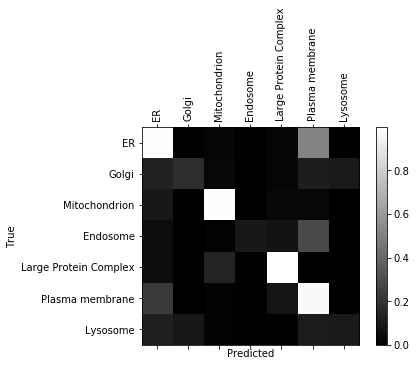

array([[ 73,   0,   2,   0,   9,  18,   0],
       [ 10,   2,   3,   0,   9,   4,   1],
       [  7,   0, 100,   0,  13,   1,   0],
       [  4,   0,   1,   3,  31,  10,   0],
       [  4,   0,  14,   0, 411,   0,   0],
       [ 17,   0,   1,   0,  33,  34,   0],
       [  9,   1,   1,   0,   1,   4,   1]])

In [66]:
y_pred_test = model.predict(x_test_pad)
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

confusion_plot_norm(y_test, y_pred_label_test, cat, axis=1)